<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [37]</a>'.</span>

# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [1]:
# parameters
experiment_results = "analysis/enrichment-summary.yaml"

In [2]:
# Parameters
experiment_results = "analysis/gpt4-enrichment-summary-2.yaml"


In [3]:
import yaml
from yaml import Loader
from collections import defaultdict
import pandas as pd
from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [4]:
#from ontogpt.utils.gene_set_utils import populate_ids_and_symbols, GeneSet
#ee = EvalEnrichment()
#ee.ontology = go
#ee.load_annotations("../tests/input/genes2go.tsv.gz")

In [5]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [6]:
# data dictionary
MODEL = "model"
METHOD = "method"
HAS_TOP_HIT = "has top term"
IN_TOP_5 = "in top 5"
IN_TOP_10 = "in top 10"
RANK = "rank"
SIZE_OVERLAP = "size overlap"
SIMILARITY = "similarity"
NR_SIZE_OVERLAP = "nr size overlap"
NR_SIMILARITY = "nr similarity"
GENESET = "geneset"
PROMPT_VARIANT = "prompt_variant"
SOURCE_GENESET = "source geneset"
GENESET_DESCRIPTION = "description"
GENESET_SIZE = "geneset_size"
TRUNCATION_FACTOR = "truncation factor"
NUM_TERMS = "num terms"
NUM_GO_TERMS = "num GO terms"
NUM_UNPARSED = "num unparsed"
TERM_IDS = "term ids"
GO_TERM_IDS = "go term ids"
GO_TERM_P_VALUES = "go term p values"
MAX_P_VALUE = "max p value"
MIN_P_VALUE = "min p value"
MEAN_P_VALUE = "mean p value"
PROPOTION_SIGNIFICANT = "proportion significant"
NOVEL = "unannotated"
NOVEL_LABELS = "unannotated labels"
NUM_NOVEL = "num unannotated"
GENE_RANDOMIZATION_FACTOR = "gene_randomization_factor"
SUMMARY = "summary"




In [7]:
from ontogpt.evaluation.enrichment.eval_enrichment import GeneSetComparison

In [8]:
# assumes comparisons have been run and concatenated (see Makefile) 
def load_comparisons():
    with open(f"../{experiment_results}") as f:
        obj = yaml.load(f, Loader)
        comps = [GeneSetComparison(**x) for x in obj]
        return comps

In [9]:
comps = load_comparisons()

In [10]:

def filter_redundant(term_ids):
    """
    find leaf nodes in a set of term ids
    """
    cumulative_ancs = set()
    visited = set()
    for t in term_ids:
        visited.add(t)
        if t in cumulative_ancs:
            # a descendant of t has been encountered
            continue
        ancs = list(go.ancestors(t, [IS_A, PART_OF]))
        cumulative_ancs.update(ancs)
        if (visited-{t}).intersection(ancs):
            # t is a descendant of a term that has been encountered
            continue
        yield t

# test
list(filter_redundant(["GO:0005773", "GO:0005634", "GO:0031965", "GO:0008150"]))

['GO:0005773', 'GO:0005634', 'GO:0008150']

In [11]:
import statistics
import re
def eval_payload(comp, payload, expected, closure):
    """
    Create a dataframe row from a payload in a comparison
    """
    expected_nr_ids = list(filter_redundant(expected.term_ids))
    name = comp.name
    model = payload.model
    method = payload.method
    if not model:
        model = "N/A"
    tf = payload.truncation_factor
    if not tf:
        tf = 1.0
    unparsed_term_ids = [t for t in payload.term_ids if not re.match(r'^\S+:w+$', t)]
    go_term_ids = [t for t in payload.term_ids if t.startswith("GO:")]
    nr_term_ids = list(filter_redundant(go_term_ids))
    obj = {MODEL: model, METHOD: method, GENESET: name, TRUNCATION_FACTOR: tf, PROMPT_VARIANT: payload.prompt_variant}
    obj[SUMMARY] = payload.summary
    name_toks = name.split("-")
    obj[SOURCE_GENESET] = "-".join(name_toks[0:-1])
    # obj[GENESET_DESCRIPTION] = comp.
    obj[GENE_RANDOMIZATION_FACTOR] = int(name_toks[-1])
    if not expected.term_ids:
        #print(f"Nothing expected for {name}")
        # top_term_id = "FAKE:123"
        return
    else:
        top_term_id = expected.term_ids[0]
    obj[HAS_TOP_HIT] = top_term_id in payload.term_ids
    in_top_5 = False
    in_top_10 = False
    if top_term_id in payload.term_ids:
        rank = payload.term_ids.index(top_term_id)
        obj[RANK] = rank
        in_top_5 = rank < 5
        in_top_10 = rank < 10
    obj[IN_TOP_5] = in_top_5
    obj[IN_TOP_10] = in_top_10
    overlap = set(go_term_ids).intersection(expected.term_ids)
    obj[SIZE_OVERLAP] = len(overlap)
    nr_overlap = set(nr_term_ids).intersection(expected_nr_ids)
    obj[NR_SIZE_OVERLAP] = len(nr_overlap)
    size_union = len(set(go_term_ids).union(expected.term_ids))
    if size_union:
        obj[SIMILARITY] = len(overlap) / len(set(go_term_ids).union(expected.term_ids))
    nr_size_union = len(set(nr_term_ids).union(expected_nr_ids))
    if nr_size_union:
        obj[NR_SIMILARITY] = len(nr_overlap) / len(set(nr_term_ids).union(expected_nr_ids))
    obj['number_of_terms'] = len(payload.term_ids)
    obj[NUM_GO_TERMS] = len(go_term_ids)
    obj[GENESET_SIZE] = len(comp.gene_symbols)
    obj[TERM_IDS] = payload.term_ids
    obj['term_strings'] = payload.term_strings
    obj[GO_TERM_IDS] = go_term_ids
    obj[NUM_TERMS] = len(payload.term_ids)
    obj[NUM_UNPARSED] = len(unparsed_term_ids)
    p_vals = []
    for t in go_term_ids:
        p_val = 1.0
        for e in expected.enrichment_results:
            if e.class_id == t:
                p_val = e.p_value_adjusted
                break
        p_vals.append(p_val)
    obj[GO_TERM_P_VALUES] = p_vals
    if p_vals:
        obj[MAX_P_VALUE] = max(p_vals)
        obj[MIN_P_VALUE] = min(p_vals)
        obj[MEAN_P_VALUE] = statistics.mean(p_vals)
        obj[PROPOTION_SIGNIFICANT] = len([v for v in p_vals if v<=0.05]) / len(p_vals)
    novel = []
    novel_labels = []
    # enriched_terms = [e.class_id for e in expected.enrichment_results]
    for t in go_term_ids:
        if t not in closure:
            novel.append(t)
            novel_labels.append(go.label(t))
    obj[NOVEL] = novel
    obj[NOVEL_LABELS] = novel_labels
    obj[NUM_NOVEL] = len(novel)
    return obj

objs = []
for comp in comps:
    expected = comp.payloads["standard"]
    closure = comp.payloads["closure"].term_ids
    #gene_set = GeneSet(name=comp.name, gene_symbols=comp.gene_symbols)
    #populate_ids_and_symbols(gene_set, hgnc)
    
    for method, payload in comp.payloads.items():
        obj = eval_payload(comp, payload, expected, closure)
        if obj:
            objs.append(obj)
            # temp
            if not obj[METHOD]:
                obj[METHOD] = method
df = pd.DataFrame(objs)
df.to_csv("enr.csv")
df

,model,method,geneset,truncation factor,prompt_variant,summary,source geneset,gene_randomization_factor,has top term,in top 5,...,num unparsed,go term p values,max p value,min p value,mean p value,proportion significant,unannotated,unannotated labels,num unannotated,rank
0,gpt-4,no_synopsis,EDS-0,1.0,v1,Summary: Connective tissue and extracellular m...,EDS,0,False,False,...,5,"[3.341122685366184e-06, 0.0002163442736878809,...",1.000000,3.341123e-06,0.333407,0.666667,[],[],0,NaN
1,gpt-4,no_synopsis,EDS-0,1.0,v2,Summary: The genes provided are primarily invo...,EDS,0,False,False,...,6,"[3.341122685366184e-06, 1.0, 1.0, 0.0018583098...",1.000000,3.341123e-06,0.401195,0.600000,[],[],0,NaN
2,gpt-4,ontological_synopsis,EDS-0,1.0,v1,Summary: The genes provided are mainly involve...,EDS,0,True,True,...,9,"[3.341122685366184e-06, 5.591343976855226e-11,...",1.000000,5.591344e-11,0.333855,0.666667,[],[],0,1.0
3,gpt-4,ontological_synopsis,EDS-0,1.0,v2,Summary: The common functional themes among th...,EDS,0,True,True,...,6,"[3.341122685366184e-06, 5.591343976855226e-11,...",1.000000,5.591344e-11,0.333423,0.666667,[],[],0,1.0
4,gpt-4,narrative_synopsis,EDS-0,1.0,v1,Summary: The genes provided are involved in va...,EDS,0,False,False,...,6,"[2.0273650307569266e-05, 1.0, 1.0, 0.000320621...",1.000000,2.027365e-05,0.666723,0.333333,[GO:0006457],[protein folding],1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,N/A,standard,HALLMARK_MYOGENESIS-1,1.0,None,None,HALLMARK_MYOGENESIS,1,True,True,...,292,"[2.846765593093547e-57, 2.1140435523378137e-54...",0.049875,2.846766e-57,0.006110,1.000000,[],[],0,0.0
1606,N/A,standard_no_ontology,HALLMARK_MYOGENESIS-1,1.0,None,None,HALLMARK_MYOGENESIS,1,False,False,...,71,"[2.1140435523378137e-54, 3.4004770831410926e-4...",1.000000,2.114044e-54,0.132209,0.873239,[],[],0,NaN
1607,N/A,random,HALLMARK_MYOGENESIS-1,1.0,None,None,HALLMARK_MYOGENESIS,1,False,False,...,154,"[1.0, 1.0, 1.0, 1.0, 0.002617387665068725, 1.0...",1.000000,3.540362e-04,0.929579,0.071429,"[GO:0042806, GO:0097546, GO:2001199, GO:000452...","[fucose binding, ciliary base, negative regula...",51,NaN
1608,N/A,rank_based,HALLMARK_MYOGENESIS-1,1.0,None,None,HALLMARK_MYOGENESIS,1,False,False,...,180,"[1.0, 1.2540149919424242e-08, 1.0, 1.0, 1.0, 0...",1.000000,3.577637e-22,0.856389,0.144444,"[GO:0006281, GO:0000398, GO:0051607, GO:000372...","[DNA repair, mRNA splicing, via spliceosome, d...",10,NaN


The above data frame has one row per run of a method

In [12]:
df[[MODEL, METHOD]].drop_duplicates()

,model,method
0,gpt-4,no_synopsis
2,gpt-4,ontological_synopsis
4,gpt-4,narrative_synopsis
6,gpt-3.5-turbo,no_synopsis
8,gpt-3.5-turbo,ontological_synopsis
10,gpt-3.5-turbo,narrative_synopsis
12,text-davinci-003,no_synopsis
14,text-davinci-003,ontological_synopsis
16,text-davinci-003,narrative_synopsis
18,N/A,standard


In [13]:
df[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
46,FA
92,HALLMARK_ALLOGRAFT_REJECTION
138,HALLMARK_ANDROGEN_RESPONSE
184,HALLMARK_ANGIOGENESIS
230,HALLMARK_APICAL_JUNCTION
276,HALLMARK_APICAL_SURFACE
322,HALLMARK_APOPTOSIS
368,HALLMARK_BILE_ACID_METABOLISM
414,HALLMARK_CHOLESTEROL_HOMEOSTASIS


## TABLE: All gene sets and their sizes

Copy this to [gene set](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=1762479413) tab

In [14]:
df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_16114/3852654709.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[SOURCE_GENESET, GENESET_SIZE]].drop_duplicates().style.hide_index()


source geneset,geneset_size
EDS,19
EDS,18
FA,19
FA,18
HALLMARK_ALLOGRAFT_REJECTION,200
HALLMARK_ALLOGRAFT_REJECTION,180
HALLMARK_ANDROGEN_RESPONSE,101
HALLMARK_ANDROGEN_RESPONSE,90
HALLMARK_ANGIOGENESIS,36
HALLMARK_ANGIOGENESIS,33


In [15]:
df[[MODEL, METHOD]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_16114/2185383538.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[MODEL, METHOD]].drop_duplicates().style.hide_index()


model,method
gpt-4,no_synopsis
gpt-4,ontological_synopsis
gpt-4,narrative_synopsis
gpt-3.5-turbo,no_synopsis
gpt-3.5-turbo,ontological_synopsis
gpt-3.5-turbo,narrative_synopsis
text-davinci-003,no_synopsis
text-davinci-003,ontological_synopsis
text-davinci-003,narrative_synopsis
N/A,standard


In [16]:
df[[MODEL, METHOD, PROMPT_VARIANT]].drop_duplicates().style.hide_index()

/var/folders/nc/m4tx21912kv1b8nk3zzx9plr0000gn/T/ipykernel_16114/1312593990.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df[[MODEL, METHOD, PROMPT_VARIANT]].drop_duplicates().style.hide_index()


model,method,prompt_variant
gpt-4,no_synopsis,v1
gpt-4,no_synopsis,v2
gpt-4,ontological_synopsis,v1
gpt-4,ontological_synopsis,v2
gpt-4,narrative_synopsis,v1
gpt-4,narrative_synopsis,v2
gpt-3.5-turbo,no_synopsis,v1
gpt-3.5-turbo,no_synopsis,v2
gpt-3.5-turbo,ontological_synopsis,v1
gpt-3.5-turbo,ontological_synopsis,v2


## Subset Analysis

In [17]:

go = get_adapter("sqlite:obo:go")
subsets = list(go.subsets())
subsets_by_term = defaultdict(list)
for subset in subsets:
    members = [m for m in go.subset_members(subset) if m.startswith("GO:")]
    for t in members:
        subsets_by_term[t].append(subset)
    members_ancs = go.ancestors(members)
    anc_subset = f"anc_of_{subset}"
    for a in members_ancs:
        if a not in members:
            subsets_by_term[a].append(anc_subset)

In [18]:
objs = []
for row in df.to_dict(orient="records"):
    for t in row[GO_TERM_IDS]:
        obj = {MODEL: row.get(MODEL), METHOD: row.get(METHOD) , "term": t, "label": go.label(t)}
        for s in subsets_by_term.get(t, []):
            obj[s] = 1
        objs.append(obj)
print(len(objs))
subsets_df=pd.DataFrame(objs) 
pd.set_option('display.max_rows', 10)
subsets_df

458722


,model,method,term,label,goslim_chembl,goslim_generic,goslim_drosophila,goslim_yeast,goslim_pombe,prokaryote_subset,...,anc_of_goslim_flybase_ribbon,anc_of_goslim_agr,goslim_mouse,anc_of_goslim_pombe,anc_of_gocheck_do_not_manually_annotate,anc_of_goslim_mouse,anc_of_goslim_plant,gocheck_do_not_annotate,gocheck_do_not_manually_annotate,goslim_synapse
0,gpt-4,no_synopsis,GO:0030198,extracellular matrix organization,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gpt-4,no_synopsis,GO:0030166,proteoglycan biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gpt-4,no_synopsis,GO:0061448,connective tissue development,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpt-4,no_synopsis,GO:0030198,extracellular matrix organization,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpt-4,no_synopsis,GO:0032964,collagen biosynthetic process,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458717,N/A,closure,GO:2001056,positive regulation of cysteine-type endopepti...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458718,N/A,closure,GO:2001267,regulation of cysteine-type endopeptidase acti...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458719,N/A,closure,GO:2001269,positive regulation of cysteine-type endopepti...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458720,N/A,closure,GO:2001286,regulation of caveolin-mediated endocytosis,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### All subsets

In [19]:
subsets_df.fillna(0).groupby([MODEL, METHOD]).mean(numeric_only=True).style.highlight_max(axis=1, props='font-weight:bold').format(precision=3)

### Core subsets

Copy this to [subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=669935942)

In [20]:
subsets_cols =  [MODEL, METHOD, "goslim_generic", "anc_of_goslim_generic", "goslim_agr", "anc_of_goslim_agr"]
subsets_grouped = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols]
means = subsets_grouped.mean(numeric_only=True)
means["closure_of_goslim_generic"] = means["goslim_generic"] + means["anc_of_goslim_generic"]
means["closure_of_goslim_agr"] = means["goslim_agr"] + means["anc_of_goslim_agr"]
means.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### TABLE: Above the shoreline in key subsets

[anc subsets tab](https://docs.google.com/spreadsheets/d/1gGO5IHEg-N0hivtHBO6-rdXtin8hPhw-zv6eYOBgXcE/edit#gid=345667144)

In [21]:
sorted_means = means.sort_values("anc_of_goslim_generic", ascending=False)
filtered = sorted_means[["anc_of_goslim_generic", "anc_of_goslim_agr"]]
filtered.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [22]:
means[["anc_of_goslim_generic", "anc_of_goslim_agr"]].sort_values("anc_of_goslim_agr", ascending=True).style.highlight_min(axis=0, props='font-weight:bold').format(precision=3)

In [23]:
# Reset the index of the pivoted DataFrame to have 'profession' as a column
#subsets_df = subsets_df.fillna(0).groupby([MODEL, METHOD])[subsets_cols].mean(numeric_only=True).reset_index()

# Melt the DataFrame to have 'category', 'profession', and 'percentage' columns
#melted_df = subsets_df.melt(id_vars=[MODEL, METHOD], var_name='subset', value_name='proportion')
#melted_df["mm"] = melted_df[MODEL] + melted_df[METHOD]
#melted_df
# Create a bar plot using Seaborn
#plt.figure(figsize=(10, 6))
#sns.barplot(x='subset', y='proportion', hue="mm", data=melted_df)
#plt.title('Subsets by method')
#plt.xlabel('Subset')
#plt.ylabel('Proportion')
#plt.legend(title='Subsets')
#plt.show()

## Evaluation

In [24]:
def agg_table(this_df, cols, exclude=[None]):
    qcols = [MODEL, METHOD] + cols
    agg_df = this_df.replace(r"_", " ", regex=True)[qcols].groupby([MODEL, METHOD]).mean(numeric_only=True)
    for x in exclude:
        agg_df= agg_df.query(f"method != '{x}'")
    return agg_df.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

pd.options.display.precision = 2
pd.set_option("display.precision", 2)

In [25]:
agg_table(df, [NUM_GO_TERMS, SIZE_OVERLAP, NR_SIZE_OVERLAP], ["standard"])

In [26]:
eval_summary_cols = [HAS_TOP_HIT, IN_TOP_5, IN_TOP_10, SIZE_OVERLAP, SIMILARITY, NUM_TERMS, NUM_GO_TERMS, NR_SIZE_OVERLAP, NR_SIMILARITY, MEAN_P_VALUE, MIN_P_VALUE, MAX_P_VALUE, PROPOTION_SIGNIFICANT, NUM_NOVEL]
agg_table(df, eval_summary_cols)

## TABLE: MAIN RESULTS

In [27]:
CORE_METRICS = [PROPOTION_SIGNIFICANT, NUM_GO_TERMS, HAS_TOP_HIT, NUM_NOVEL, NUM_UNPARSED]
EXCLUDE = ["standard", "standard no ontology", "random", "rank based", "closure"]
agg_table(df, CORE_METRICS, EXCLUDE)
#means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## as above, no perturbation

In [28]:
df_no_perturb = df.query(f"{GENE_RANDOMIZATION_FACTOR} == 0")
agg_table(df_no_perturb, CORE_METRICS, EXCLUDE)


## Maximums

In [29]:
df[[MODEL, METHOD] + eval_summary_cols].groupby([MODEL, METHOD]).max(numeric_only=True).style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

### Effect of truncation

Larger gene sets penalize annotation-based GPT methods due to the necessity to truncate to fit in the window size.



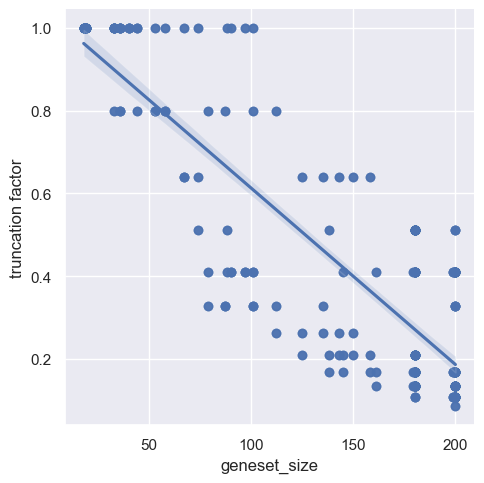

In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "regression")))
sns.lmplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=df.query("method=='ontological_synopsis'"))
plt.show()

<Axes: xlabel='geneset_size', ylabel='truncation factor'>

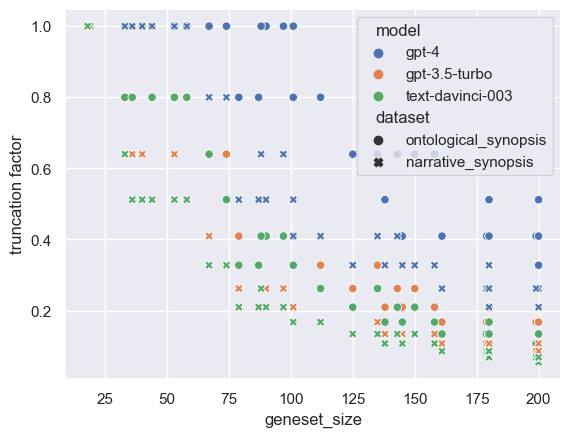

In [31]:
dftups = [(method, df.query(f"method=='{method}'")) for method in ["ontological_synopsis", "narrative_synopsis"]]
for m, mdf in dftups:
    mdf.assign(dataset=m)
concatenated = pd.concat([mdf.assign(dataset=m) for m, mdf in dftups])
sns.scatterplot(x=GENESET_SIZE, y=TRUNCATION_FACTOR, data=concatenated, style='dataset', hue='model')

In [32]:
df.query(f"{GENESET_SIZE} < 50")[[SOURCE_GENESET]].drop_duplicates()

,source geneset
0,EDS
46,FA
184,HALLMARK_ANGIOGENESIS
276,HALLMARK_APICAL_SURFACE
920,HALLMARK_HEDGEHOG_SIGNALING


In [33]:
df_small = df.query(f"{GENESET_SIZE} < 50")
means = df_small[[MODEL, METHOD] + eval_summary_cols].groupby(['model', 'method']).mean(numeric_only=True)
means

has top term  in top 5  in top 10  \
model            method                                                    
N/A              closure                       1.00      0.00       0.00   
                 random                        0.00      0.00       0.00   
                 rank_based                    0.10      0.00       0.00   
                 standard                      1.00      1.00       1.00   
                 standard_no_ontology          0.50      0.50       0.50   
...                                             ...       ...        ...   
gpt-4            no_synopsis                   0.15      0.15       0.15   
                 ontological_synopsis          0.40      0.40       0.40   
text-davinci-003 narrative_synopsis            0.20      0.20       0.20   
                 no_synopsis                   0.20      0.20       0.20   
                 ontological_synopsis          0.20      0.20       0.20   

                                       size overlap  similarity  num terms  \
model            method                                                      
N/A              closure                     116.00    6.87e-02    2625.40   
                 random                        1.30    9.51e-03      28.60   
                 rank_based                    3.10    3.02e-02      29.60   
                 standard                    116.00    9.69e-01     120.50   
                 standard_no_ontology         21.80    2.18e-01      29.70   
...                                             ...         ...        ...   
gpt-4            no_synopsis                   2.45    2.27e-02       6.70   
                 ontological_synopsis          3.30    3.86e-02       8.35   
text-davinci-003 narrative_synopsis            1.70    1.36e-02      11.40   
                 no_synopsis                   1.35    1.17e-02       6.40   
                 ontological_synopsis          1.65    1.80e-02      11.10   

                                       num GO terms  nr size overlap  \
model            method                                                
N/A              closure                    2579.20             2.80   
                 random                       28.60             0.30   
                 rank_based                   29.60             0.60   
                 standard                    116.00            17.20   
                 standard_no_ontology         29.70             5.70   
...                                             ...              ...   
gpt-4            no_synopsis                   4.15             0.90   
                 ontological_synopsis          6.70             1.65   
text-davinci-003 narrative_synopsis            4.35             0.85   
                 no_synopsis                   3.00             0.40   
                 ontological_synopsis          6.85             0.80   

                                       nr similarity  mean p value  \
model            method                                              
N/A              closure                    1.68e-02      9.25e-01   
                 random                     7.03e-03      9.62e-01   
                 rank_based                 1.91e-02      8.95e-01   
                 standard                   9.78e-01      8.59e-03   
                 standard_no_ontology       2.14e-01      2.32e-01   
...                                              ...           ...   
gpt-4            no_synopsis                4.64e-02      4.11e-01   
                 ontological_synopsis       8.44e-02      4.45e-01   
text-davinci-003 narrative_synopsis         4.20e-02      6.11e-01   
                 no_synopsis                1.90e-02      5.37e-01   
                 ontological_synopsis       4.04e-02      7.39e-01   

                                       min p value  max p value  \
model            method                                           
N/A              closure                  3.71e-10   

In [34]:
means.query("method != 'standard'").style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

## TABLE: evaluation for gene sets < 75

In [35]:
agg_table(df_small, CORE_METRICS, EXCLUDE)

## Looking at individual gene sets

In [36]:

def terms_summary(df, variant="v1", max_rows=9999):
    term_dict = {}
    n = 0
    for _, row in df.iterrows():
        if row[PROMPT_VARIANT] and row[PROMPT_VARIANT] != variant:
            continue
        n += 1
        if n > max_rows:
            break
        model = row['model'] 
        if "turbo" in model:
            model = "turbo"
        elif "davinci" in model:
            model = "dav"
        else:
            model = ""
        method = str(row['method']).replace('_', ' ')
        if method in ["closure", "rank_based", "random"]:
            continue
        mm = f"{model} {method}"
        if method == "standard":
            nr_term_ids = list(filter_redundant(row[TERM_IDS]))
        else:
            nr_term_ids = None
        for ix, t_id in enumerate(row[TERM_IDS]):
            if t_id not in term_dict:
                t = {"id": t_id, "label": go.label(t_id), "redundant": False}
                term_dict[t_id] = t
            else:
                t = term_dict[t_id]
            t[mm] = ix
            if nr_term_ids and t_id not in nr_term_ids:
                t["redundant"] = True
    objs = list(term_dict.values())
    return pd.DataFrame(objs)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [37]:
import oaklib.datamodels.obograph as og
from oaklib.utilities.obograph_utils import graph_to_image, default_stylemap_path
!mkdir -p output

MMAP = {"standard": None, 
        "gpt-3.5-turbo.no_synopsis": "NS",
        "gpt-3.5-turbo.ontological_synopsis": "ONT",
        "gpt-3.5-turbo.narrative_synopsis": "NAR",
       }

def viz(geneset, include_std=True, mmap = MMAP, variant="v1"):
    methods = mmap.keys()
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    terms = set()
    terms.add("GO:0008150")
    terms.add("GO:0003674")
    terms.add("GO:0005575")
    m2t = defaultdict(list)
    t2m = defaultdict(set)
    seeds = []
    for m in methods:
        if m == "standard":
            mv = m
        else:
            mv = f"{m}.{variant}"
        p = gsobj.payloads[mv]
        if include_std or m != "standard":
            terms.update(p.term_ids)
        for t in p.term_ids:
            if t.startswith("MONDO:"):
                continue
            m2t[m].append(t)
            t2m[t].add(m)
            if m == "standard":
                seeds.append(t)
    # rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF, "RO:0002211", "RO:0002212", RO:0002213"])
    rels = go.gap_fill_relationships(list(terms), predicates=[IS_A, PART_OF])
    g = go.relationships_to_graph(rels)
    for n in g.nodes:
        if not n.lbl:
            n.lbl = go.label(n.id)
        if not n.lbl:
            n.lbl = n.id
        if n.id in t2p:
            n.lbl += f" {t2p[n.id]:.2e}"
        #for m in t2m[n.id]:
        #    n.lbl += f" [<b>{m}</b>]"
    for m in m2t.keys():
        if m == "standard":
            continue
        for t in m2t[m]:
            n = og.Node(id=f"{mmap[m]}:{t}", lbl=mmap[m])
            g.nodes.append(n)
            g.edges.append(og.Edge(n.id, "has", t))
    outfile = f"output/{geneset.replace(' ', '_')}-{include_std}-{variant}.png"
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="input/enr-style.json")
    graph_to_image(g, seeds=seeds, imgfile=outfile, stylemap="input/enr-style.json")
    #return g
    
viz('peroxisome-0')
viz('peroxisome-0', variant="v2")

ValueError: not enough values to unpack (expected 1, got 0)

In [ ]:
def geneset_summary(df, geneset):
    sdf = terms_summary(df.query(f"{GENESET} == '{geneset}'").sort_values("similarity", ascending=False))
    [gsobj] = [c for c in comps if c.name == geneset]
    std = gsobj.payloads["standard"]
    t2p = {e.class_id : e.p_value_adjusted for e in std.enrichment_results}
    sdf["p_label"] = sdf.apply(lambda row: str(row.label) + " " + str(t2p.get(row.id, "")), axis=1)
    return sdf

geneset_summary(df, 'peroxisome-0')

### Peroxisome

In [ ]:
peroxisome = df.query(f"{GENESET} == 'peroxisome-0'").sort_values("similarity", ascending=False)
peroxisome[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
# terms_summary(peroxisome).style.highlight_min(axis=1, props='font-weight:bold', numeric_only=True)
terms_summary(peroxisome)

In [ ]:
terms_summary(peroxisome, "v2")

## Sensory Ataxia

In [ ]:
ataxia = df.query(f"{GENESET} == 'sensory ataxia-0'").sort_values("similarity", ascending=False)
ataxia[[MODEL, METHOD] + eval_summary_cols]                                                  

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


In [ ]:
ataxia[[MODEL, METHOD, PROMPT_VARIANT, GO_TERM_IDS, NOVEL_LABELS]]

In [ ]:
viz('sensory ataxia-0')

![img](output/sensory_ataxia-0-True-v1.png)

In [ ]:
viz('sensory ataxia-0', variant="v2")

![img](output/sensory_ataxia-0-True-v2.png)

In [ ]:
terms_summary(ataxia)

In [ ]:
def retrieve_payload(geneset, method):
    for comp in comps:
        if comp.name == geneset:
            return comp.payloads[method]

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.ontological_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.narrative_synopsis.v1").response_text)

In [ ]:
print(retrieve_payload("sensory ataxia-0", "gpt-3.5-turbo.no_synopsis.v1").response_text)

## T cell proliferation

In [ ]:
tcp = df.query(f"{GENESET} == 'T cell proliferation-0'").sort_values("similarity", ascending=False)
tcp[[MODEL, METHOD] + eval_summary_cols]

In [ ]:
viz('T cell proliferation-0')

![img](output/T_cell_proliferation-0-True.png)

In [ ]:
terms_summary(tcp)

## Endocytosis

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").prompt)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.narrative_synopsis").response_text)

In [ ]:
print(retrieve_payload("endocytosis-0", "gpt-3.5-turbo.ontological_synopsis").prompt)

## Hydrolysis

In [ ]:
hydrolysis = df.query(f"{GENESET} == 'hydrolase activity, hydrolyzing O-glycosyl compounds-0'").sort_values("similarity", ascending=False)
terms_summary(hydrolysis)

In [ ]:
viz('hydrolase activity, hydrolyzing O-glycosyl compounds-0')

## Variability

In [ ]:
pv_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=PROPOTION_SIGNIFICANT)
# Calculate differences between run "1" and run "2"
pv_pivot['diff'] = pv_pivot["v1"] - pv_pivot["v2"]
pv_pivot

In [ ]:

# Now you can perform statistics on the 'diff' column
df_diff_stats = pv_pivot['diff'].agg(['mean', 'std', 'var', 'min', 'max'])
df_diff_stats['range'] = df_diff_stats['max'] - df_diff_stats['min']
df_diff_stats

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# pivot your dataframe as before
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=TERM_IDS, aggfunc=list)
df_pivot

In [ ]:

# calculate Jaccard index for each group
df_pivot['jaccard_index'] = df_pivot.apply(lambda row: jaccard_similarity(row["v1"][0], row["v2"][0]), axis=1)

# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
result['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL])['jaccard_index'].describe()

In [ ]:
result.groupby([MODEL, METHOD])['jaccard_index'].describe()[['count', 'mean', 'std', 'min', 'max']].style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
summaries = [s for s in list(df[SUMMARY]) if s]
len(summaries)
import random
def random_summary():
    return summaries[int(random.random() * len(summaries))]

random_summary()

In [ ]:
from ontogpt.clients import OpenAIClient

simclient = OpenAIClient(model="text-embedding-ada-002")

def text_similarity(text1, text2):
    return simclient.similarity(text1, text2)

text_similarity("nucleus of cell", "nuclear membrane")

In [ ]:
text_similarity(random_summary(), random_summary())

In [ ]:
rs = random_summary()
text_similarity(rs, rs)

In [ ]:
sims = [text_similarity(random_summary(), random_summary()) for i in range(1,200)]

In [ ]:
import statistics
avg_sim = statistics.mean(sims)
avg_sim

In [ ]:
df_pivot = df.pivot_table(index=[MODEL, METHOD, GENESET], columns=PROMPT_VARIANT, values=SUMMARY, aggfunc=list)
df_pivot

df_pivot['sim'] = df_pivot.apply(lambda row: text_similarity(row["v1"][0], row["v2"][0]), axis=1)

# reset index to get it back in the form of a DataFrame
result = df_pivot.reset_index()
result

In [ ]:
sim_summary = result.groupby([MODEL, METHOD])['sim'].describe()[['count', 'mean', 'std', 'min', 'max']]
sim_summary.style.highlight_max(axis=0, props='font-weight:bold').format(precision=3)

In [ ]:
stats_df = result.groupby(METHOD).agg({'sim': [np.mean, np.std]}).reset_index()
stats_df.columns = ['category', 'mean', 'stddev']

# Set the plot style
sns.set(style="whitegrid")

# Create the bar plot with error bars
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='category', y='mean', data=stats_df, yerr=stats_df['stddev'], capsize=.1)

# Add labels and title
plt.xlabel("Category")
plt.ylabel("Mean Score")
plt.title("Mean Score with Standard Deviation for Each Category")

# Show the plot
plt.show()


## Hallucinations

In [ ]:
def hallucinatons(df, model):
    novel_term_map = defaultdict(dict)
    for _, row in df.iterrows():
        gs = row[GENESET]
        #if not gs.endswith("-0"):
        #    continue
        gs = gs.replace("-0", "")
        for lbl in row[NOVEL_LABELS]:
            if row[MODEL] != model:
                continue
            m = row[METHOD]
            novel_term_map[lbl]["NAME"] = lbl
            if gs not in novel_term_map[lbl]:
                novel_term_map[lbl][m] = []
            novel_term_map[lbl][m].append(gs)
    novel_df = pd.DataFrame(novel_term_map.values())
    return novel_df

In [ ]:
novel_df_turbo = hallucinatons(df, TURBO).reset_index(drop=True)
novel_df_turbo

In [ ]:
hallucinatons(df, DAVINCI)

## New Annotations

In [ ]:
endocytosis = df.query(f"{GENESET} == 'endocytosis-0'").sort_values("similarity", ascending=False)
terms_summary(endocytosis)

In [ ]:
viz('endocytosis-0')

![img](output/endocytosis-0-True-v1.png)

### New Annotations

in 2022-03-24, GO `molecular sequesting` only had 6 genes annotated; this increased to 30 in 2023.
If these are past the LLM training date then we would not expect these to influence results. Additionally,


In [ ]:
sequestering = df.query(f"{GENESET} == 'molecular sequestering-0'").sort_values("similarity", ascending=False)
sequestering[eval_summary_cols]                                                           

In [ ]:
terms_summary(sequestering)

In [ ]:
viz('molecular sequestering-0')

![img](output/molecular_sequestering-0-True-v1.png)

## IGRB

This gene set contains genes previously annotated to IGRB, many of which have been since removed

In [ ]:
igrb = df.query(f"{GENESET} == 'ig-receptor-binding-2022-0'").sort_values("similarity", ascending=False)
terms_summary(igrb)

In [ ]:
viz('ig-receptor-binding-2022-0')

![img](output/ig-receptor-binding-2022-0-True-v1.png)

## Summaries

In [ ]:
objs = []
for c in comps:
    for m, payload in c.payloads.items():
        if payload.summary:
            objs.append({"model": c.model, "geneset": c.name, "method": m, "summary": payload.summary})

In [ ]:
sdf = pd.DataFrame(objs)

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
sdf

In [ ]:
sdf.query("geneset == 'sensory ataxia-0'")